# importing stuff and checking if everything is installed

In [1]:
# I ran this in an env with pip install vina rdkit meeko molscrub spyrmsd py3Dmol scikit-learn matplotlib jupyterlab
from vina import Vina
from scrubber import Scrub
from rdkit import Chem
from meeko import MoleculePreparation
from meeko import PDBQTWriterLegacy
from meeko import PDBQTMolecule
from meeko import RDKitMolCreate
from spyrmsd.molecule import Molecule
from spyrmsd.rmsd import rmsdwrapper


#quiet down rdkit warnings
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*') 

ModuleNotFoundError: No module named 'rdkit.six'

# ligand preparation
AutoDock Vina authors recommend Meeko for Ligand preparation. Meeko has a handy python API which we will use. We need to pick out a relevant protomer/tautomer, add explicit Hs and generate a sensible conformation, for this purpose we use the tool MolScrub.

In [59]:
# for generating protomers, tautomers, explicitHs
scrub = Scrub(ph_low=7.4,ph_high=7.4) #physiological pH

def mol_to_pdbqt(mol):
    """
    input: an rdkit mol
    output: a pdbqt string for use in vina docking
    """
    # run scrub and take the first protomer/tautomer
    mol_state = scrub(mol)[0]
    # set up meeko preparation pipeline
    mk_prep = MoleculePreparation()
    molsetup_list = mk_prep(mol_state)
    molsetup = molsetup_list[0]
    # write setup to pdbqt block
    pdbqt_string = PDBQTWriterLegacy.write_string(molsetup)
    return pdbqt_string[0]

def pdbqt_to_mols(pdbqts,scores,name,idx=0):
    """
    input: a pdbqt string with (possibly several)
    output: array of rdkit mols with properties
    """
    pdbqtmols = PDBQTMolecule(pdbqts)
    m = RDKitMolCreate.from_pdbqt_mol(pdbqtmols)[0]
    m.SetProp("Score",",".join([str(s) for s in scores]))
    m.SetProp("_Name",name)
    m.SetProp("Idx",str(idx))
    m.ClearProp("meeko")
    return m

m = Chem.MolFromSmiles("c2ccccc2CCN(CCCF)Cc2ccccc2") # a molecule
lig = mol_to_pdbqt_block(m)

# Receptor preparation (SKIPPED)
Meeko can also be used to prepare a receptor for docking from a PDB file, using one of the helper scripts. However, cleaning up a PDB file usually requires tricky manual intervention so we will use prepared PDBQTs and config files. These were sourced from: https://github.com/dockstring/dockstring/tree/main/dockstring/resources/targets if you would like to know more about automatic protein preparation for Vina look here: https://ccsb.scripps.edu/adfr/downloads/

For this example notebook, we're using DRD3 (dopamine receptor D3), a GPCR with high expression in the CNS and relevance to disease processes including those related to schizophrenia, addiction and Parkinson's.


# Docking a single molecule
to show how to use the Vina python bindings

In [120]:
# random molecule
mol = Chem.MolFromSmiles("c1c(Cl)c(Cl)ccc1N1CCN(C)CC1")
#scoring function: vina; verbose output
v = Vina(sf_name='vina',verbosity=2)
# our provided target protein
v.set_receptor("DRD3_target.pdbqt")
# get ligand from rdkit mol using our helper function
v.set_ligand_from_string(mol_to_pdbqt_block(mol)) 
#provided settings
v.compute_vina_maps(center=[8.970,21.132,24.193], box_size=[25, 25, 25])
#docking with 8 trials retaining the 5 best scores poses
v.dock(exhaustiveness=8, n_poses=5)

Computing Vina grid ... done.


Performing docking (random seed: -1912764849) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
done.


# Docking molecules
we write a helper script that iterates through a list of mols and returns the docked poses (as multiconformer rdkit mols) and saves them to SDF 

In [124]:
def dock_mols(mols,outfile="out.sdf",
              receptor_file='DRD3_target.pdbqt',
              save_output=True,
              exhaustiveness=8,
              n_poses=5):
    docked_mols = []
    v = Vina(sf_name='vina',verbosity=0) #scoring function: vina
    
    for idx,mol in enumerate(mols):
        if "_Name" not in mol.GetPropsAsDict():
            name = Chem.MolToSmiles(mol)
        else:
            name = Chem.GetProp("_Name")
        v.set_receptor(receptor_file)
        v.set_ligand_from_string(mol_to_pdbqt_block(mol))
        v.compute_vina_maps(center=[8.970,21.132,24.193], box_size=[25, 25, 25]) #provided settings
        v.dock(exhaustiveness=exhaustiveness, n_poses=n_poses)
        scores = [float(e[0]) for e in v.energies()]
        poses = v.poses()
        docked_mols.append(pdbqt_to_mols(poses,scores,name,idx))
    
    #save the poses as sdf
    if save_output:
        wri = Chem.SDWriter(outfile)
        for m in docked_mols:
            scores = [float(s) for s in m.GetProp("Score").split(",")]
            for i,score in enumerate(scores):
                m.SetProp("Score",str(score))
                wri.write(m,confId=i)
        wri.close()
    return docked_mols

#test the function with two random molecules
ms = [Chem.MolFromSmiles(smi) for smi in ["c1ccccc1CC(C)NCC","Clc1c(Cl)ccc(CCOCCC2CNC2)c1"]]
dock_mols(ms)

# Docking reference
How good is Vina at recovering our reference ligand's pose? We can redock the molecule (from SMILES, without coordinate information) and compare it with the coordinates from the PDB. Pose recovery is usually assessed using the RMSD, where an RMSD under 2 Angstrom's is considered a successful recovery.

In [151]:
# load the reference
ref = Chem.MolFromMol2File("reference_pose.mol2")
# convert to smiles
mol = Chem.MolFromSmiles(Chem.MolToSmiles(ref))
#dock mol using wrapper
docked_mol = dock_mols([mol])[0]
# convert rdkit mols to spyrmsd mols
ref_s = Molecule.from_rdkit(ref)
docked_mol_s = Molecule.from_rdkit(docked_mol)
#calculate RMSD
rms = rmsdwrapper(ref_s, docked_mol_s)[0]
if rms<2:
    print(f"It worked. Docking was successful with RMSD of {rms}")
else:
    print(f"It failed. RMSD of {rms}, which is over 2.")

It worked. Docking was successful with RMSD of 1.1567860018239355


# Show the overlay in 3D
using py3Dmol JS widget

In [152]:

v = py3Dmol.view(width=300,height=300)
v.removeAllModels()
IPythonConsole.addMolToView(Chem.RemoveHs(ref),v,confId=0)
IPythonConsole.addMolToView(Chem.RemoveHs(docked_mol),v,confId=0)
v.zoomTo()
v.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Virtual screening efficacy of docking
10 true hits and 90 decoys are provided. How good is docking at distinguishing the hits from the non hits? Warning, this cell takes about 15 minutes to run (on my laptop).

In [134]:
#load mols
actives = [m for m in Chem.SmilesMolSupplier("actives.smi",titleLine=False) if m]
decoys = [m for m in Chem.SmilesMolSupplier("decoys.smi",titleLine=False) if m]
docked_actives = dock_mols(actives)
docked_decoys = dock_mols(decoys)

Maybe this molecule is "too" symmetric? C02054947 O=C(N[C@H](Nc1ccccc1C(F)(F)F)C(Cl)(Cl)Cl)c1ccccc1[N+](=O)[O-]


Maybe this molecule is "too" symmetric? C19315797 CC(C)(C)C(=O)N[C@@H]([NH+]1CCCCCC1)C(Cl)(Cl)Cl


# Visualize the scoring difference
Using the AUC curve. This show moderate classification success, typical for docking

In [145]:
docking_scores = []
label = []
#clean up scores
for active in docked_actives:
    label.append(1)
    #get best score only
    docking_scores.append(float(active.GetProp("Score").split(",")[0]))
for decoy in docked_decoys:
    label.append(0)
    #get best score only
    docking_scores.append(float(decoy.GetProp("Score").split(",")[0]))

0.6433333333333333


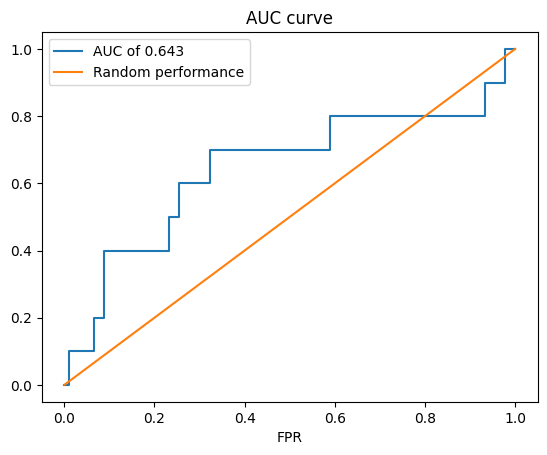

In [150]:
from sklearn.metrics import roc_curve,roc_auc_score
from matplotlib import pyplot as plt

print(roc_auc_score(label, [-x for x in docking_scores]))
fpr, tpr, _ = roc_curve(label, [-x for x in docking_scores], pos_label=1)
plt.plot(fpr,tpr,label=f"AUC of {round(roc_auc_score(label, [-x for x in docking_scores]),3)}")
plt.plot([0,1],[0,1],label="Random performance")
plt.title("AUC curve")
plt.xlabel("FPR")
plt.ylabel("")
plt.legend()
plt.show()